In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/twitter_data_train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/twitter_data_test.csv')

In [ ]:
train_data.shape

(31962, 3)

In [ ]:
test_data.shape

(17197, 2)

In [ ]:
combined_data = train_data.append(test_data,ignore_index=True,sort=True)

<ipython-input-6-5a96ec643edf>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_data = train_data.append(test_data,ignore_index=True,sort=True)


In [ ]:
combined_data.shape


(49159, 3)

In [ ]:
def remove_pattern(text,pattern):
  r = re.findall(pattern,text)

  for i in r:
    text = re.sub(i,"",text)

  return text

In [ ]:
import re
combined_data['Tidy_tweets'] = np.vectorize(remove_pattern) (combined_data['tweet'],"@[\w]*")

In [ ]:
combined_data['Tidy_tweets'] = combined_data['Tidy_tweets'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
combined_data.head()

,id,label,tweet,Tidy_tweets
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit can't cause they don't off...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model love take with time urð±!!! ððð...
4,5,0.0,factsguide: society now #motivation,factsguide: society #motivation


In [ ]:
tokenized_tweet = combined_data['Tidy_tweets'].apply(lambda x: x.split())

In [ ]:
import nltk
from nltk import PorterStemmer

In [ ]:
ps = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [ps.stem(i) for i in x])

for i in range(len(tokenized_tweet)):
  tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

combined_data['Tidy_tweets'] = tokenized_tweet

In [ ]:
def Hashtags_Extract(x):
  Hashtags = []

  for i in x:
    ht = re.findall(r'#(\w+)',i)
    Hashtags.append(ht)

  return Hashtags

In [ ]:
ht_positive = Hashtags_Extract(combined_data['Tidy_tweets'][combined_data['label']==0])
ht_positive_unnest = sum(ht_positive,[])

ht_negative = Hashtags_Extract(combined_data['Tidy_tweets'][combined_data['label']==1])
ht_negative_unnest = sum(ht_negative,[])

<Axes: xlabel='Count', ylabel='Hashtags'>

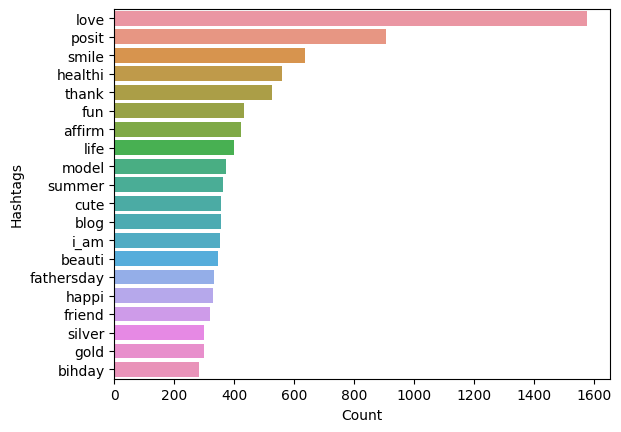

In [ ]:
word_freq_positive = nltk.FreqDist(ht_positive_unnest)

df_positive = pd.DataFrame({'Hashtags': list(word_freq_positive.keys()),'Count': list(word_freq_positive.values())})

df_positive_plot = df_positive.nlargest(20,columns = 'Count')

sns.barplot(data = df_positive_plot,y='Hashtags',x='Count')

<Axes: xlabel='Count', ylabel='Hashtags'>

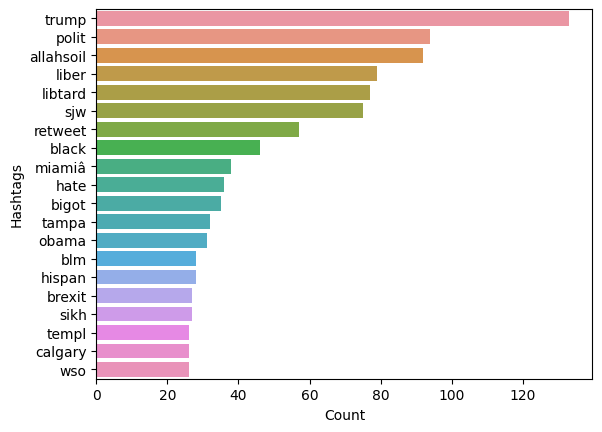

In [ ]:
word_freq_negative = nltk.FreqDist(ht_negative_unnest)

df_negative = pd.DataFrame({'Hashtags': list(word_freq_negative.keys()),'Count': list(word_freq_negative.values())})

df_negative_plot = df_negative.nlargest(20,columns = 'Count')

sns.barplot(data = df_negative_plot,y='Hashtags',x='Count')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf=TfidfVectorizer(max_df=0.90, min_df=2,max_features=1000,stop_words='english')

tfidf_matrix = tfidf.fit_transform(combined_data['Tidy_tweets'])

df_tfidf = pd.DataFrame(tfidf_matrix.todense())


In [ ]:
train_tfidf_matrix = tfidf_matrix[:31962]

train_tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train_tfidf,x_test_tfidf,y_train_tfidf,y_test_tfidf = train_test_split(train_tfidf_matrix,train_data['label'],test_size = 0.3, random_state =17)

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
Log_Reg = LogisticRegression(random_state =0,solver='lbfgs')

In [ ]:
Log_Reg.fit(x_train_tfidf,y_train_tfidf)

prediction_tfidf = Log_Reg.predict_proba(x_test_tfidf)

prediction_tfidf

array([[0.9851486 , 0.0148514 ],
       [0.98165445, 0.01834555],
       [0.91765531, 0.08234469],
       ...,
       [0.96152298, 0.03847702],
       [0.93455831, 0.06544169],
       [0.97841261, 0.02158739]])

In [ ]:
from sklearn.metrics import f1_score

prediction_int = prediction_tfidf[:,1]>=0.3

prediction_int = prediction_int.astype(int)

log_tfidf = f1_score(y_test_tfidf,prediction_int)

log_tfidf

0.585160202360877

In [ ]:
from xgboost import XGBClassifier

In [ ]:
model_tfidf = XGBClassifier(random_state=29,learning_rate=0.7)

model_tfidf.fit(x_train_tfidf,y_train_tfidf)

xgb_tfidf=model_tfidf.predict_proba(x_test_tfidf)

xgb_tfidf

array([[0.99739784, 0.00260214],
       [0.99149156, 0.00850846],
       [0.95537794, 0.04462209],
       ...,
       [0.9021414 , 0.09785861],
       [0.95537794, 0.04462209],
       [0.98855627, 0.01144375]], dtype=float32)

In [ ]:
xgb_tfidf=xgb_tfidf[:,1]>=0.3
xgb_int_tfidf=xgb_tfidf.astype(np.int)

score=f1_score(y_test_tfidf,xgb_int_tfidf)

score

<ipython-input-28-7d53eb4a6bb6>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xgb_int_tfidf=xgb_tfidf.astype(np.int)


0.592